# 15. 복수 모델 선별

In [18]:
library(tidymodels)
tidymodels_prefer()
data(concrete, package = "modeldata")
glimpse(concrete)

Rows: 1,030
Columns: 9
$ cement               <dbl> 540.0, 540.0, 332.5, 332.5, 198.6, 266.0, 380.0, ~
$ blast_furnace_slag   <dbl> 0.0, 0.0, 142.5, 142.5, 132.4, 114.0, 95.0, 95.0,~
$ fly_ash              <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0~
$ water                <dbl> 162, 162, 228, 228, 192, 228, 228, 228, 228, 228,~
$ superplasticizer     <dbl> 2.5, 2.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,~
$ coarse_aggregate     <dbl> 1040.0, 1055.0, 932.0, 932.0, 978.4, 932.0, 932.0~
$ fine_aggregate       <dbl> 676.0, 676.0, 594.0, 594.0, 825.5, 670.0, 594.0, ~
$ age                  <int> 28, 28, 270, 365, 360, 90, 365, 28, 28, 28, 90, 2~
$ compressive_strength <dbl> 79.99, 61.89, 40.27, 41.05, 44.30, 47.03, 43.70, ~


In [22]:
concrete <- concrete %>% 
    group_by(across(-compressive_strength)) %>% 
    summarize(compressive_strength = mean(compressive_strength),
             .groups = "drop")
glimpse(concrete)

Rows: 992
Columns: 9
$ cement               <dbl> 102.0, 102.0, 102.0, 102.0, 108.3, 108.3, 108.3, ~
$ blast_furnace_slag   <dbl> 153.0, 153.0, 153.0, 153.0, 162.4, 162.4, 162.4, ~
$ fly_ash              <dbl> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,~
$ water                <dbl> 192.0, 192.0, 192.0, 192.0, 203.5, 203.5, 203.5, ~
$ superplasticizer     <dbl> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,~
$ coarse_aggregate     <dbl> 887.0, 887.0, 887.0, 887.0, 938.2, 938.2, 938.2, ~
$ fine_aggregate       <dbl> 942.0, 942.0, 942.0, 942.0, 849.0, 849.0, 849.0, ~
$ age                  <int> 3, 7, 28, 90, 3, 7, 28, 90, 3, 7, 28, 90, 3, 7, 2~
$ compressive_strength <dbl> 4.57, 7.68, 17.28, 25.46, 2.33, 7.72, 20.59, 29.2~


# 
- 데이터 분할

In [23]:
set.seed(1501)
concrete_split <- initial_split(concrete, strata = compressive_strength)
concrete_train <- training(concrete_split)
concrete_test  <- testing(concrete_split)

set.seed(1502)
concrete_folds <- 
   vfold_cv(concrete_train, strata = compressive_strength, repeats = 5)

# 
- 전처리 recipe 설정

In [24]:
normalized_rec <- 
   recipe(compressive_strength ~ ., data = concrete_train) %>% 
   step_normalize(all_predictors()) 

poly_recipe <- 
   normalized_rec %>% 
   step_poly(all_predictors()) %>% 
   step_interact(~ all_predictors():all_predictors())

# 
- 복수 모델 생성

In [28]:
library(rules)
library(baguette)

In [29]:
linear_reg_spec <- linear_reg(penalty = tune(), mixture = tune()) %>% 
    set_engine("glmnet")

nnet_spec <- mlp(hidden_units = tune(), penalty = tune(), epochs = tune()) %>% 
    set_engine("nnet", MaxNWts = 2600) %>% 
    set_mode("regression")

mars_spec <- mars(prod_degree = tune()) %>%  #<- use GCV to choose terms
    set_engine("earth") %>% 
    set_mode("regression")

svm_r_spec <- svm_rbf(cost = tune(), rbf_sigma = tune()) %>% 
    set_engine("kernlab") %>% 
    set_mode("regression")

svm_p_spec <- svm_poly(cost = tune(), degree = tune()) %>% 
    set_engine("kernlab") %>% 
    set_mode("regression")

knn_spec <- nearest_neighbor(neighbors = tune(), dist_power = tune(), weight_func = tune()) %>% 
    set_engine("kknn") %>% 
    set_mode("regression")

cart_spec <- decision_tree(cost_complexity = tune(), min_n = tune()) %>% 
    set_engine("rpart") %>% 
    set_mode("regression")

bag_cart_spec <- bag_tree() %>% 
    set_engine("rpart", times = 50L) %>% 
    set_mode("regression")

rf_spec <- rand_forest(mtry = tune(), min_n = tune(), trees = 1000) %>% 
    set_engine("ranger") %>% 
    set_mode("regression")

xgb_spec <- boost_tree(tree_depth = tune(), learn_rate = tune(), loss_reduction = tune(),
                       min_n = tune(), sample_size = tune(), trees = tune()) %>% 
    set_engine("xgboost") %>% 
    set_mode("regression")

cubist_spec <- cubist_rules(committees = tune(), neighbors = tune()) %>% 
    set_engine("Cubist") 

In [33]:
nnet_param <- nnet_spec %>%
    extract_parameter_set_dials() %>%
    update(hidden_units = hidden_units(c(1, 27)))

nnet_param %>% print

Collection of 3 parameters for tuning

   identifier         type    object
 hidden_units hidden_units nparam[+]
      penalty      penalty nparam[+]
       epochs       epochs nparam[+]



# 
# 
# 
## 15.2 워크플로 생성

- 예측 변수만 표준화하는 레시피를 예측 변수가 동일한 단위로 있어야 하는 비선형 모델에 결합

In [35]:
normalized <- workflow_set(preproc = list(normalized = normalized_rec), 
                           models = list(SVM_radial = svm_r_spec, SVM_poly = svm_p_spec, 
                                         KNN = knn_spec, neural_network = nnet_spec))
normalized %>% print

# A workflow set/tibble: 4 x 4
  wflow_id                  info             option    result    
  <chr>                     <list>           <list>    <list>    
1 normalized_SVM_radial     <tibble [1 x 4]> <opts[0]> <list [0]>
2 normalized_SVM_poly       <tibble [1 x 4]> <opts[0]> <list [0]>
3 normalized_KNN            <tibble [1 x 4]> <opts[0]> <list [0]>
4 normalized_neural_network <tibble [1 x 4]> <opts[0]> <list [0]>


- 전처리 레시피가 하나만 있으므로 이 함수는 이 값을 가진 워크플로우 집합을 생성. 
- 전처리 레시피가 하나 이상의 엔트리를 포함하고 있다면, 함수는 전처리 레시피와 모델의 모든 조합을 생성

# 



- info 열에는 일부 식별자와 워크플로 개체가 포함된 티블이 포함. 
- 특정 워크플로를 추출할 수 있습니다.

In [36]:
normalized %>% extract_workflow(id = "normalized_KNN") 

== Workflow ============================================================================================================
Preprocessor: Recipe
Model: nearest_neighbor()

-- Preprocessor --------------------------------------------------------------------------------------------------------
1 Recipe Step

* step_normalize()

-- Model ---------------------------------------------------------------------------------------------------------------
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = tune()
  dist_power = tune()

Computational engine: kknn 


# 
- 옵션 열은 워크플로우를 평가할 때 사용할 모든 인수의 자리 표시자
    - 신경망 매개 변수 개체를 추가:

In [38]:
normalized <- normalized %>% 
    option_add(param_info = nnet_param, id = "normalized_neural_network")
normalized %>% print

# A workflow set/tibble: 4 x 4
  wflow_id                  info             option    result    
  <chr>                     <list>           <list>    <list>    
1 normalized_SVM_radial     <tibble [1 x 4]> <opts[0]> <list [0]>
2 normalized_SVM_poly       <tibble [1 x 4]> <opts[0]> <list [0]>
3 normalized_KNN            <tibble [1 x 4]> <opts[0]> <list [0]>
4 normalized_neural_network <tibble [1 x 4]> <opts[1]> <list [0]>


- result 열은 튜닝 또는 리샘플링 기능의 출력을 위한 자리 표시자


# 
# 
# 

- 다른 비선형 모델의 경우 결과 및 예측 변수에 대해 dplyr 선택기를 사용하는 다른 워크플로 세트를 생성



In [39]:
model_vars <- workflow_variables(outcomes = compressive_strength, predictors = everything())

In [40]:
no_pre_proc <- workflow_set(preproc = list(simple = model_vars),
                            models = list(MARS = mars_spec, CART = cart_spec, CART_bagged = bag_cart_spec,
                                          RF = rf_spec, boosting = xgb_spec, Cubist = cubist_spec))

In [41]:
no_pre_proc %>% print

# A workflow set/tibble: 6 x 4
  wflow_id           info             option    result    
  <chr>              <list>           <list>    <list>    
1 simple_MARS        <tibble [1 x 4]> <opts[0]> <list [0]>
2 simple_CART        <tibble [1 x 4]> <opts[0]> <list [0]>
3 simple_CART_bagged <tibble [1 x 4]> <opts[0]> <list [0]>
4 simple_RF          <tibble [1 x 4]> <opts[0]> <list [0]>
5 simple_boosting    <tibble [1 x 4]> <opts[0]> <list [0]>
6 simple_Cubist      <tibble [1 x 4]> <opts[0]> <list [0]>


# 
# 
- 마지막으로, 적절한 모델과 비선형항 및 상호 작용을 사용하는 세트를 조립

In [42]:
with_features <- workflow_set(preproc = list(full_quad = poly_recipe), 
                              models = list(linear_reg = linear_reg_spec, KNN = knn_spec))

# 
# 
# 
- 모든 workflow_set결합


In [43]:
all_workflows <- bind_rows(no_pre_proc, normalized, with_features) %>% 
    mutate(wflow_id = gsub("(simple_)|(normalized_)", "", wflow_id))

In [44]:
all_workflows %>% print

# A workflow set/tibble: 12 x 4
   wflow_id             info             option    result    
   <chr>                <list>           <list>    <list>    
 1 MARS                 <tibble [1 x 4]> <opts[0]> <list [0]>
 2 CART                 <tibble [1 x 4]> <opts[0]> <list [0]>
 3 CART_bagged          <tibble [1 x 4]> <opts[0]> <list [0]>
 4 RF                   <tibble [1 x 4]> <opts[0]> <list [0]>
 5 boosting             <tibble [1 x 4]> <opts[0]> <list [0]>
 6 Cubist               <tibble [1 x 4]> <opts[0]> <list [0]>
 7 SVM_radial           <tibble [1 x 4]> <opts[0]> <list [0]>
 8 SVM_poly             <tibble [1 x 4]> <opts[0]> <list [0]>
 9 KNN                  <tibble [1 x 4]> <opts[0]> <list [0]>
10 neural_network       <tibble [1 x 4]> <opts[1]> <list [0]>
11 full_quad_linear_reg <tibble [1 x 4]> <opts[0]> <list [0]>
12 full_quad_KNN        <tibble [1 x 4]> <opts[0]> <list [0]>


# 
# 
# 
## 15.3 모델 튜닝 및 평가
- all_workflow의 대부분의 모델에는 튜닝 매개 변수가 포함
- 성능을 평가하기 위해 표준 튜닝 또는 리샘플링 기능(예: tune_grid() 등)을 사용
- ```workflow_map()``` 함수는 집합에 있는 모든 워크플로에 동일한 함수를 적용

# 

- 최대 25개의 다른 파라미터 후보를 사용하여 각 워크플로에 그리드 서치가 적용
- ```tune_grid()```의 각 실행에서 사용할 수 있는 일반적인 옵션들이 존재 :
    - 각 워크플로에 대해 동일한 리샘플링 및 제어 개체를 그리드 크기 25와 함께 사용



In [45]:
grid_ctrl <- control_grid(save_pred = TRUE,
                          parallel_over = "everything",
                          save_workflow = TRUE)

In [ ]:
grid_results <- all_workflows %>%
    workflow_map(seed = 1503,
                 resamples = concrete_folds,
                 grid = 25,
                 control = grid_ctrl)

In [ ]:
grid_results %>% print

```#> # A tibble: 252 × 4
#>   model      .config                rmse  rank
#>   <chr>      <chr>                 <dbl> <int>
#> 1 boost_tree Preprocessor1_Model04  4.25     1
#> 2 boost_tree Preprocessor1_Model06  4.29     2
#> 3 boost_tree Preprocessor1_Model13  4.31     3
#> 4 boost_tree Preprocessor1_Model14  4.39     4
#> 5 boost_tree Preprocessor1_Model16  4.46     5
#> 6 boost_tree Preprocessor1_Model03  4.47     6
#> # … with 246 more rows```

- option열에는 workflow_map() 호출에서 사용한 모든 옵션이 포함
- result열에서 "tune[+]" 및 "rsmp[+]" 표기법은 객체에 문제가 없음을 의미
- 어떤 이유로 인해 모든 모형이 고장나면 "tune[x]"와 같은 값이 발생.

# 
# 

### ```rank_results()``` :  일부 성능 메트릭에 따라 모델을 정렬
- 기본적으로 메트릭 세트(이 경우 RMSE)의 첫 번째 메트릭을 사용
- 또한 모든 후보 집합의 순위를 매기므로 동일한 모델이 출력에 여러 번 나타날 수 있음. 
- ```select_best```라는 옵션을 사용하여 최상의 튜닝 매개 변수 조합을 사용하여 모델의 순위를 지정할 수 있음


In [ ]:
grid_results %>% rank_results(select_best = TRUE) %>% 
    filter(.metric == "rmse") %>% 
    select(model, .config, rmse = mean, rank)

- 각 워크플로의 최적 모델 구성에 대한 추정 RMSE(및 대략적인 신뢰 구간)

In [ ]:
autoplot(grid_results,
         rank_metric = "rmse",  # <- how to order models
         metric = "rmse",       # <- which metric to visualize
         select_best = TRUE     # <- one point per workflow
) +
    geom_text(aes(y = mean - 1/2, label = wflow_id), angle = 90, hjust = 1) +
    lims(y = c(3.5, 9.5)) +
    theme(legend.position = "none")

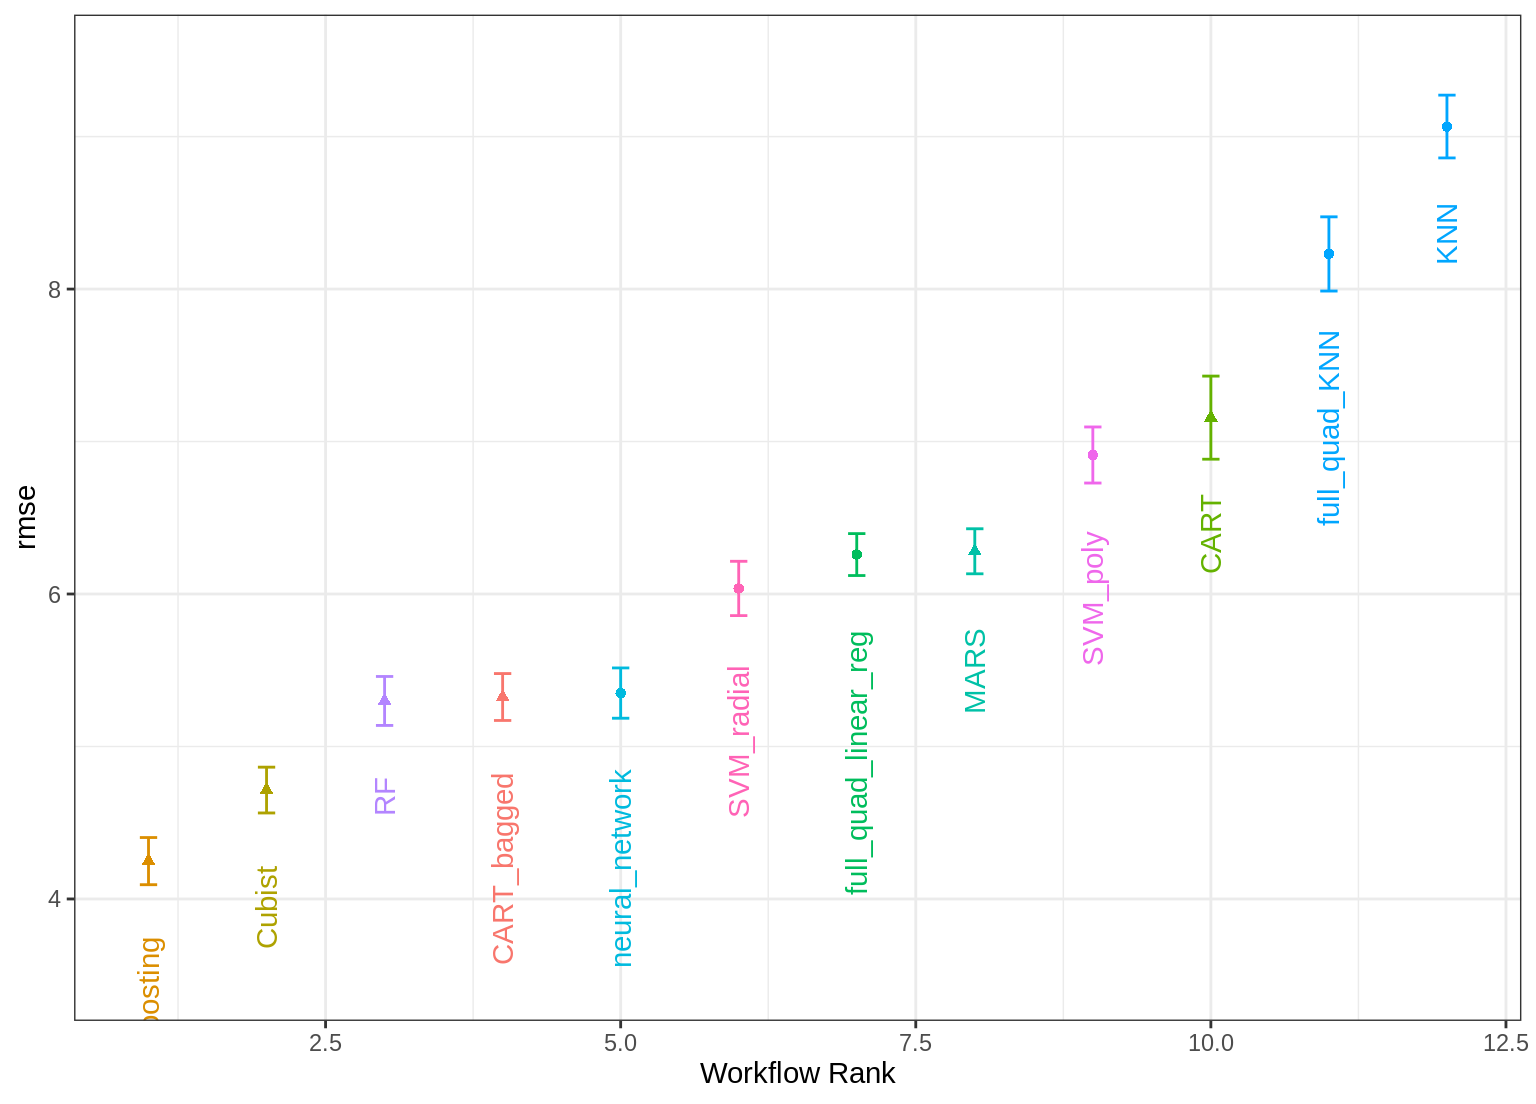

# 

- 특정 모델에 대한 튜닝 매개 변수 결과를 보려면 ```id``` 인수는 표시할 모델에 대한 ```wflow_id``` 입력


In [ ]:
autoplot(grid_results, id = "Cubist", metric = "rmse")

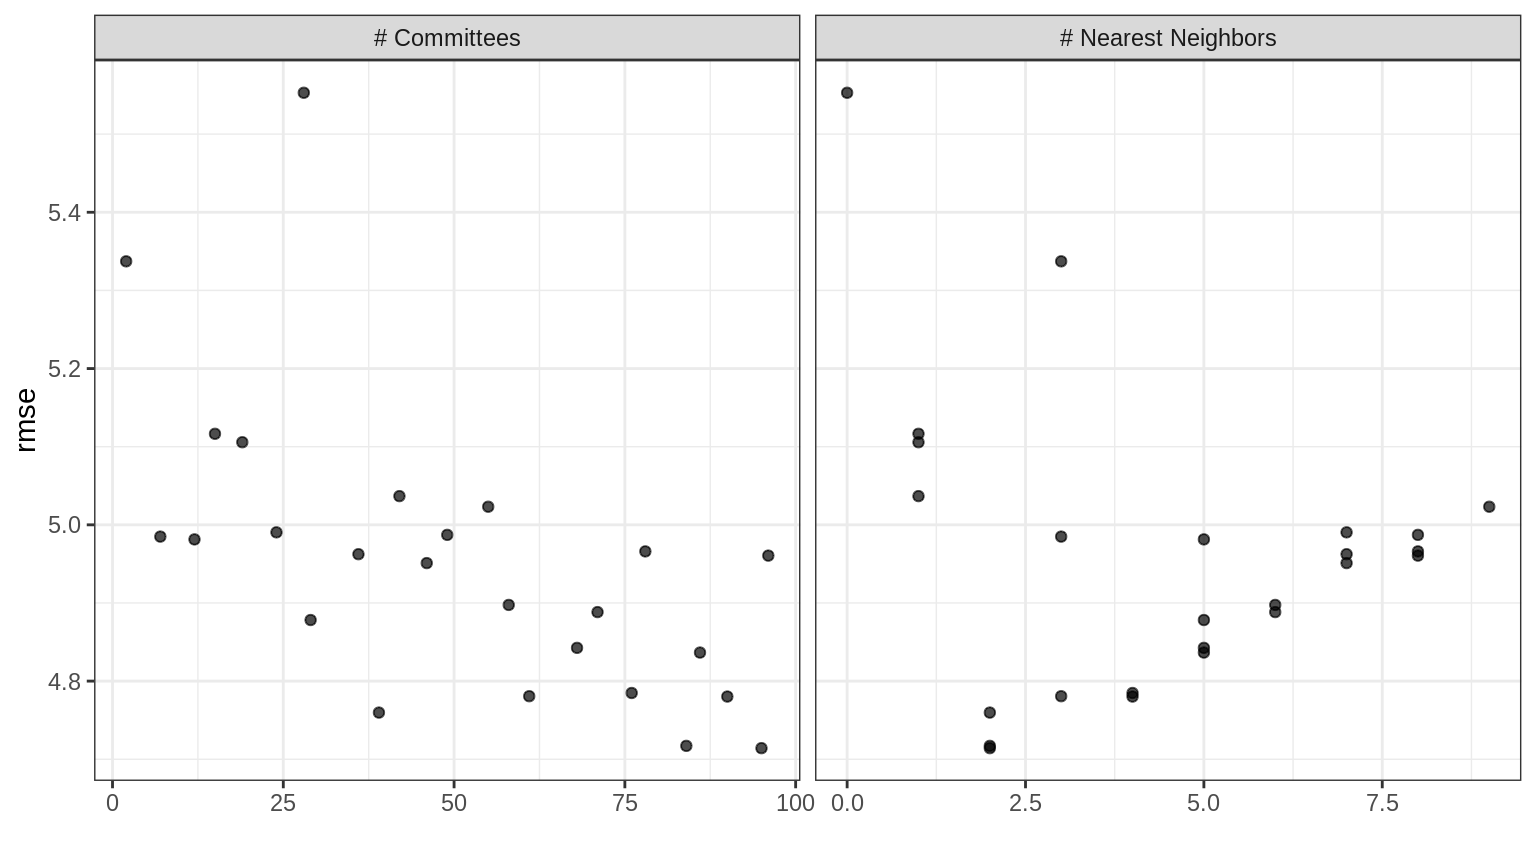

- ```collect_predictions()```와 ```collect_metrics()```에 대한 메서드도 존재.



# 
# 
# 
## 15.4 효율적인 모델 선별
- **많은 모델들을 효율적으로 선별하기 위한 효과적인 방법 중 하나는 Racing Method**
- 워크플로 세트를 사용하면 이 Racing Method에 대해 ```workflow_map()``` 함수를 사용할 수 있음. 
- 워크플로 집합에서 파이핑한 후 사용하는 인수는 워크플로에 적용하는 함수이며, 이 경우 ```"tune_race_anova"``` 값을 사용할 수 있음. 또한 적절한 제어 개체를 전달. 

In [ ]:
library(finetune)

In [ ]:
race_ctrl <- control_race(save_pred = TRUE,
                          parallel_over = "everything",
                          save_workflow = TRUE)

In [ ]:
race_results <- all_workflows %>%
    workflow_map("tune_race_anova",
                 seed = 1503,
                 resamples = concrete_folds,
                 grid = 25,
                 control = race_ctrl)

- result 열의 요소가 "race[+]" 값을 나타냄

In [ ]:
race_results %>% print

```#> # A workflow set/tibble: 12 × 4
#>   wflow_id    info             option    result   
#>   <chr>       <list>           <list>    <list>   
#> 1 MARS        <tibble [1 × 4]> <opts[3]> <race[+]>
#> 2 CART        <tibble [1 × 4]> <opts[3]> <race[+]>
#> 3 CART_bagged <tibble [1 × 4]> <opts[3]> <rsmp[+]>
#> 4 RF          <tibble [1 × 4]> <opts[3]> <race[+]>
#> 5 boosting    <tibble [1 × 4]> <opts[3]> <race[+]>
#> 6 Cubist      <tibble [1 × 4]> <opts[3]> <race[+]>
#> # … with 6 more rows```

# 
- Racing Method 결과의 각 워크플로에서 최상의 모델 구성에 대한 추정 RMSE(및 대략적인 신뢰 구간)

In [ ]:
autoplot(race_results,
         rank_metric = "rmse",  
         metric = "rmse",       
         select_best = TRUE    
) +
    geom_text(aes(y = mean - 1/2, label = wflow_id), angle = 90, hjust = 1) +
    lims(y = c(3.0, 9.5)) +
    theme(legend.position = "none")

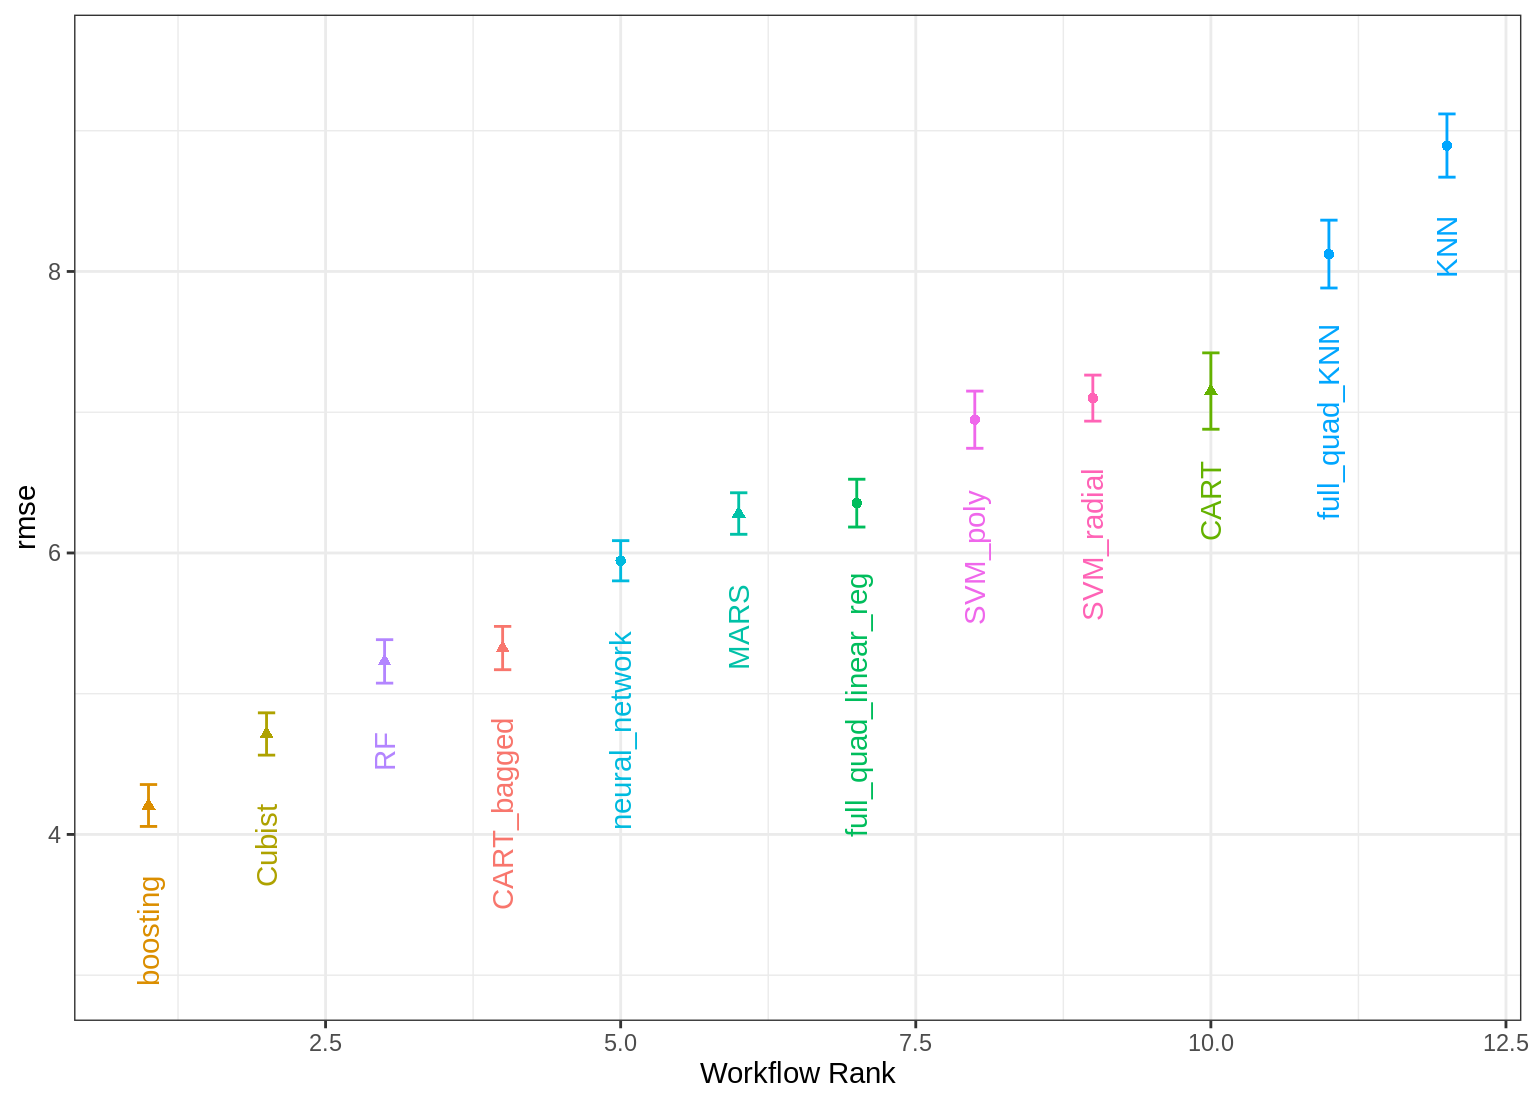

# 
# 
- 결과를 순위를 매기고 병합


In [ ]:
matched_results <- rank_results(race_results, select_best = TRUE) %>% 
    select(wflow_id, .metric, race = mean, config_race = .config) %>% 
    inner_join(rank_results(grid_results, select_best = TRUE) %>% 
                   select(wflow_id, .metric, complete = mean, config_complete = .config, model),
               by = c("wflow_id", ".metric"),) %>%  
    filter(.metric == "rmse")

- 전체 그리드 및 Racing Method에 대한 추정 RMSE.



In [ ]:
library(ggrepel)

In [ ]:
matched_results %>% ggplot(aes(x = complete, y = race)) + 
    geom_abline(lty = 3) + 
    geom_point() + 
    geom_text_repel(aes(label = model)) +
    coord_obs_pred() + 
    labs(x = "Complete Grid RMSE", y = "Racing RMSE") 

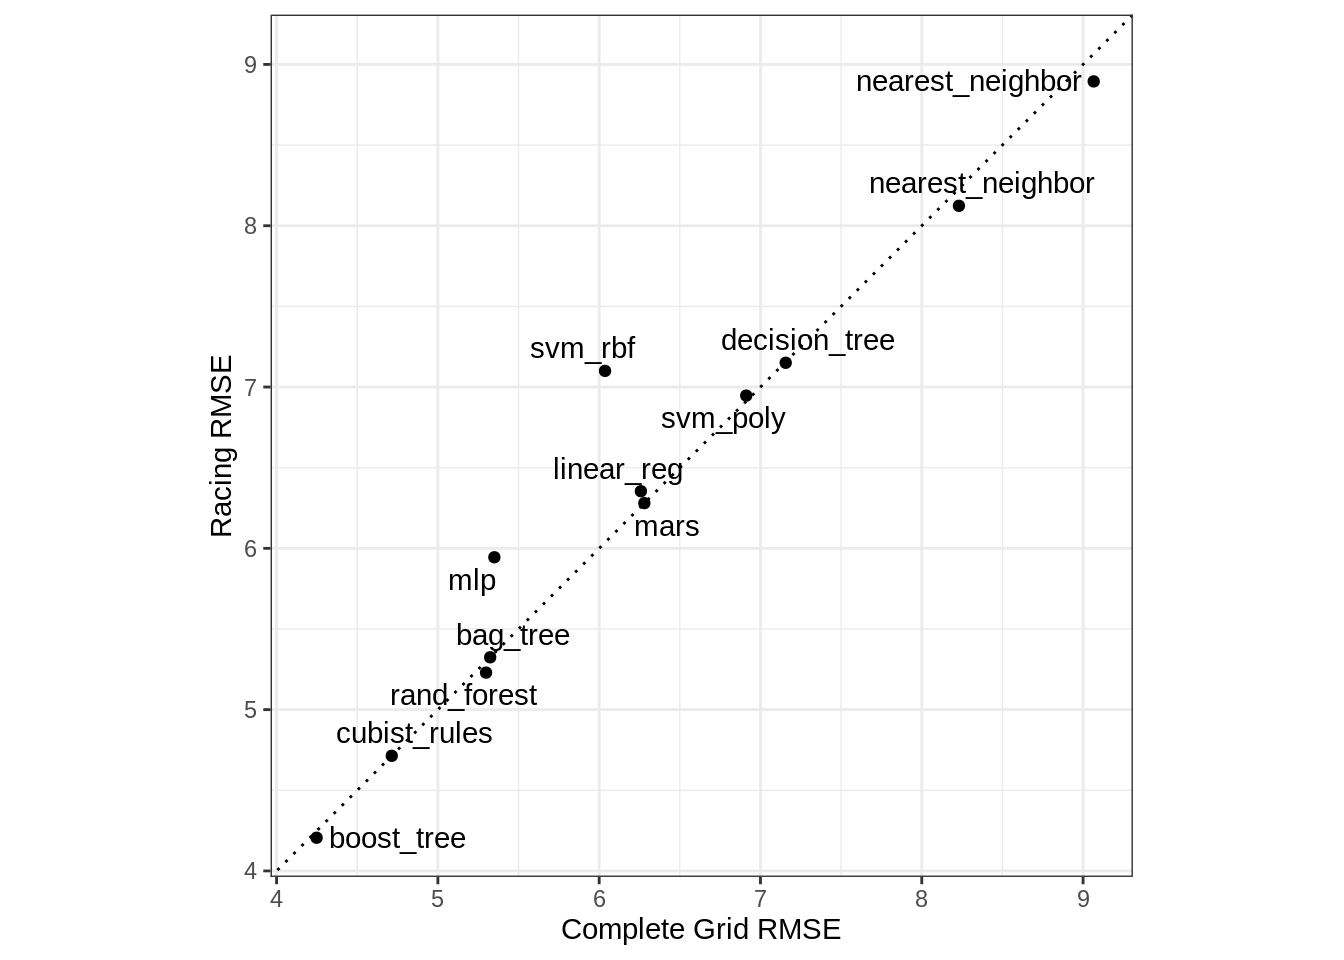

- Racing Method는 모델의 41.67%에 대해서만 전체 그리드와 동일한 후보 파라미터를 선택한 반면, Racing Method로 선택한 모델의 성능 지표는 거의 동일
- **RMSE 값의 상관관계는 0.968, 순위 상관관계는 0.951 => 이는 모형 내에서 거의 동일한 결과를 가진 여러 튜닝 파라미터 조합이 있었음을 나타냄**


# 
# 
# 
## 15.5 모델 최종 선정
1. **최종 사용할 워크플로 선택**
    - Boosted tree 모델이 잘 작동했으므로 세트에서 해당 항목을 추출하고 
    - 파라미터를 수치적으로 최적의 설정으로 업데이트한 후 훈련 세트에 적합


In [ ]:
best_results <- race_results %>% 
    extract_workflow_set_result("boosting") %>% 
    select_best(metric = "rmse")

best_results %>% print

```
#> # A tibble: 1 × 8
#>   .order trees min_n tree_depth learn_rate loss_reduction sample_size .config       
#>    <int> <int> <int>      <int>      <dbl>          <dbl>       <dbl> <chr>         
#> 1     16  1957     8          7     0.0756    0.000000145       0.679 Preprocessor1…```

In [ ]:
boosting_test_results <- race_results %>% 
    extract_workflow("boosting") %>% 
    finalize_workflow(best_results) %>% 
    last_fit(split = concrete_split)

- 테스트 세트 메트릭 결과를 확인

In [ ]:
collect_metrics(boosting_test_results) %>% print

```#> # A tibble: 2 × 4
#>   .metric .estimator .estimate .config             
#>   <chr>   <chr>          <dbl> <chr>               
#> 1 rmse    standard       3.33  Preprocessor1_Model1
#> 2 rsq     standard       0.956 Preprocessor1_Model1```

In [ ]:
boosting_test_results %>% 
    collect_predictions() %>% 
    ggplot(aes(x = compressive_strength, y = .pred)) + 
    geom_abline(color = "gray50", lty = 2) + 
    geom_point(alpha = 0.5) + 
    coord_obs_pred() + 
    labs(x = "observed", y = "predicted")

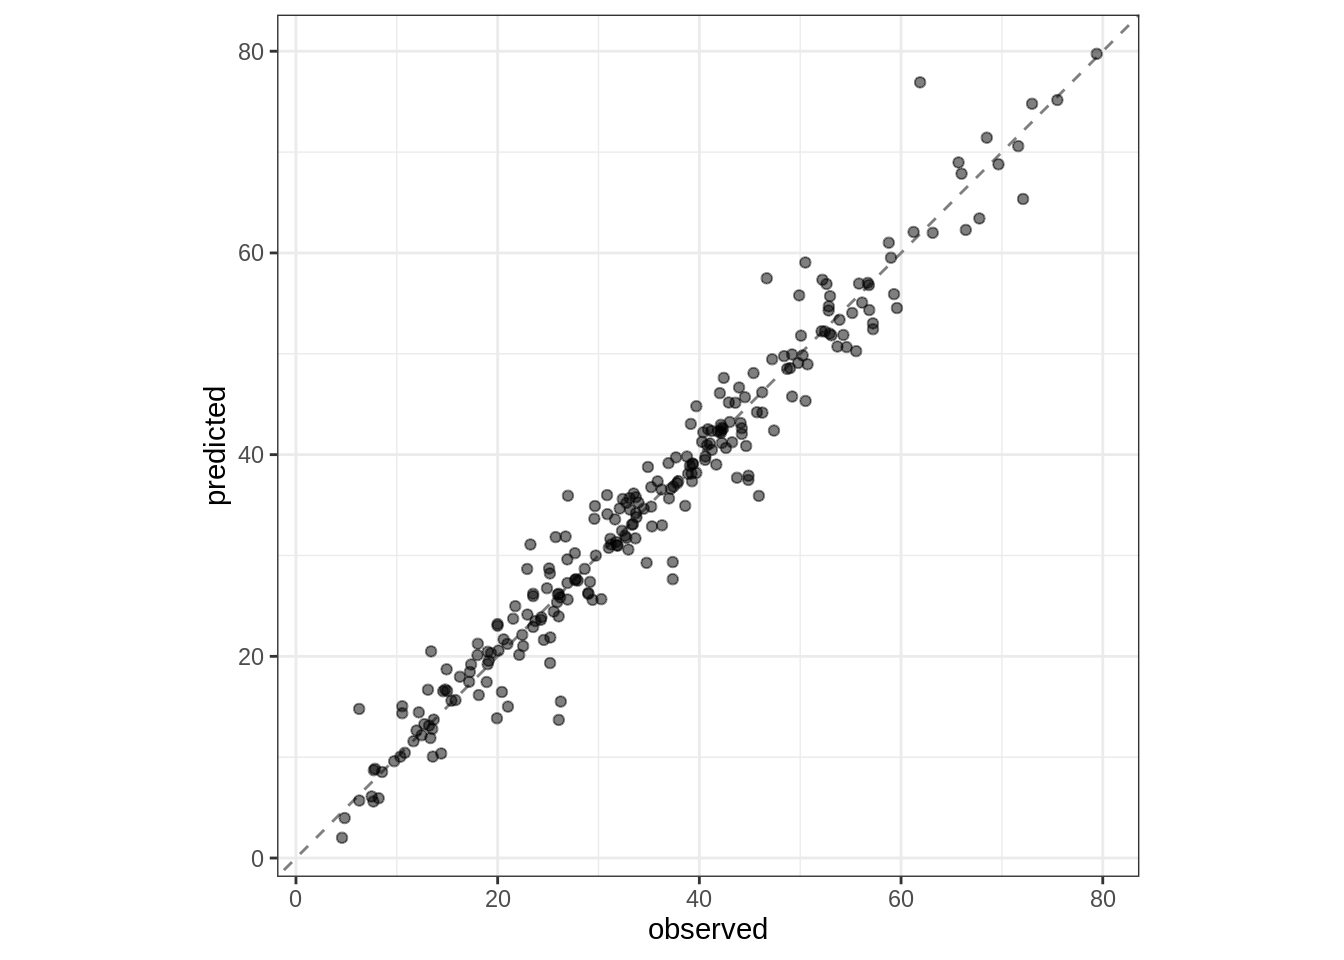